In [1]:
import pandas as pd

# Load main user dataset
df = pd.read_csv("../data/cleaned_github_users.csv")

# Load content-based scores
content_df = pd.read_csv("../data/content_scores.csv")
content_df = content_df.rename(columns={"score": "content_score"})

# Load collaborative filtering scores
collab_df = pd.read_csv("../data/collab_recommendations.csv")
collab_df = collab_df.rename(columns={"similarity": "collab_score"})

# Load TF-IDF-based bio scores
bio_df = pd.read_csv("../data/bio_recommendations.csv")
bio_df = bio_df.rename(columns={"bio_score": "bio_score"})

# Load Semantic Bio similarity scores
semantic_df = pd.read_csv("../data/bio_semantic_scores.csv")
# For hybrid, we need only the best semantic score per user
semantic_best = semantic_df.groupby('Username')['semantic_bio_score'].max().reset_index()

# Start building hybrid dataframe
hybrid_df = df[['Username', 'Languages', 'Repositories', 'Location', 'Profile_URL']].copy()

# Merge in all components
hybrid_df = hybrid_df.merge(content_df[['Username', 'content_score']], on='Username', how='left')
hybrid_df = hybrid_df.merge(collab_df[['Username', 'collab_score']], on='Username', how='left')
hybrid_df = hybrid_df.merge(bio_df[['Username', 'bio_score']], on='Username', how='left')
hybrid_df = hybrid_df.merge(semantic_best, on='Username', how='left')

# Fill missing values
hybrid_df.fillna(0, inplace=True)

# 🧠 Weight tuning - adjust for best performance
w_content = 0.4
w_collab = 0.3
w_bio = 0.1
w_semantic = 0.2

# Compute hybrid score
hybrid_df['hybrid_score'] = (
    w_content * hybrid_df['content_score'] +
    w_collab * hybrid_df['collab_score'] +
    w_bio * hybrid_df['bio_score'] +
    w_semantic * hybrid_df['semantic_bio_score']
)

# Optional explanation column
hybrid_df['explanation'] = hybrid_df.apply(lambda row: (
    f"Content: {row['content_score']:.2f}, "
    f"Collab: {row['collab_score']:.2f}, "
    f"Bio-TFIDF: {row['bio_score']:.2f}, "
    f"Bio-Semantic: {row['semantic_bio_score']:.2f}"
), axis=1)

# Sort by hybrid score
hybrid_df_sorted = hybrid_df.sort_values(by='hybrid_score', ascending=False)

# 🔄 Recommendation Function
def recommend_hybrid(username, preferred_location=None, top_k=5):
    if username not in hybrid_df_sorted['Username'].values:
        print("❌ Username not found.")
        return pd.DataFrame()

    recs = hybrid_df_sorted[hybrid_df_sorted['Username'] != username].copy()

    if preferred_location:
        recs = recs[recs['Location'].str.contains(preferred_location, case=False, na=False)]

    return recs[['Username', 'Languages', 'Location', 'Profile_URL', 'hybrid_score', 'explanation']].head(top_k)

# ✅ Example usage
recommendations = recommend_hybrid("abhay", preferred_location="India")
print("\n🔍 Top Hybrid Recommendations with Semantic Bio:\n")
print(recommendations)

# 💾 Save final hybrid scores
hybrid_df_sorted.to_csv("../data/final_hybrid_with_semantic.csv", index=False)
print("✅ Final hybrid recommendations saved to data/final_hybrid_with_semantic.csv")



🔍 Top Hybrid Recommendations with Semantic Bio:

         Username                                          Languages  \
3834  ubuntufreak                     Python, ApacheConf, JavaScript   
267   anildigital              JavaScript, Elixir, Ruby, Scala, HTML   
532   vishnugopal  JavaScript, Java, PHP, C, Ruby, Haskell, TypeS...   
227      danahern             JavaScript, Java, C, C++, Ruby, Python   
1273        jerry                                   CSS, Scala, Ruby   

                       Location                     Profile_URL  hybrid_score  \
3834                      India  https://github.com/ubuntufreak      0.589289   
267                 Pune, India  https://github.com/anildigital      0.561098   
532   Thiruvananthapuram, India  https://github.com/vishnugopal      0.551323   
227               Indianola, WA     https://github.com/danahern      0.538658   
1273         Westfield, Indiana        https://github.com/jerry      0.535543   

                              

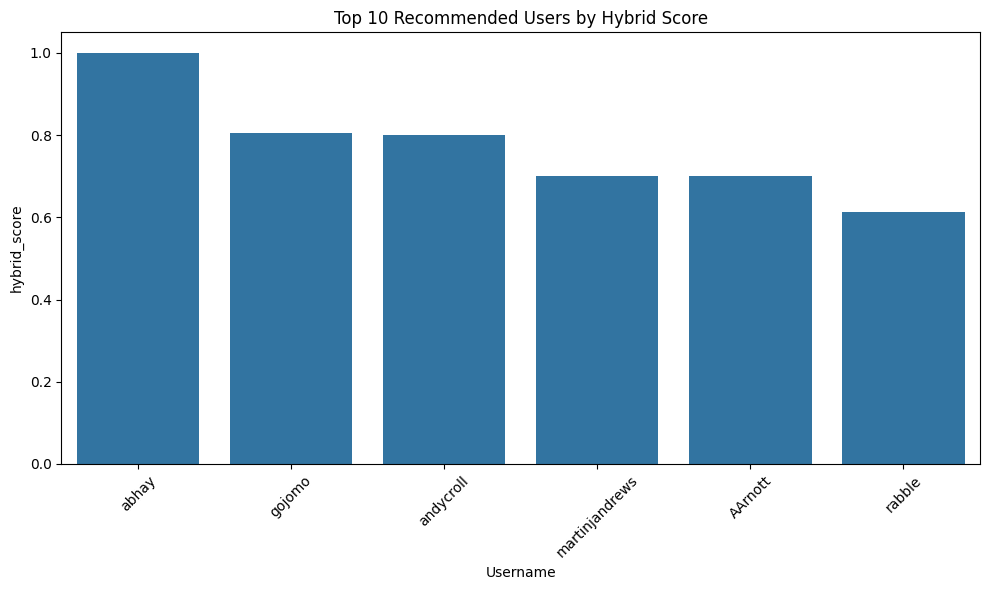

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

top_hybrid = hybrid_df_sorted.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Username', y='hybrid_score', data=top_hybrid)
plt.title("Top 10 Recommended Users by Hybrid Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
